# Import Module

In [1]:
import torch
import glob
import warnings 
warnings.filterwarnings('ignore')

import random
import PIL
import cv2
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

from torch.utils.data import Dataset, DataLoader

# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


# Set seed and config

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [4]:
CFG={'SEED' : 42,
     'IMAGE_SIZE' : 256,
     'EPOCHS' : 15,
     'BATCH_SIZE' : 64,
     'LR' : 0.001,
     'model_save_path' : f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/model_save_path/Practice.pt"}

In [5]:
seed_everything(CFG['SEED'])

# Get Data Path

In [6]:
def get_path(path):
    normal=[]
    p=[]

    normal_label = []
    p_label = []

    for t in os.listdir(path):
        if t=='NORMAL':
            normal_path = f"{path}{t}\\"
            for normal_data in glob.glob(normal_path + "/*.jpeg"):
                normal.append(normal_data)
                normal_label.append(np.array([1,0]))

        elif t=='PNEUMONIA':
            p_path = f"{path}{t}\\"
            for p_data in glob.glob(p_path + "/*.jpeg"):
                p.append(p_data)
                p_label.append(np.array([0,1]))

    return normal, p, normal_label, p_label

#Train
train_path = "C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/chest_xray/train/"
train_normal, train_p, train_normal_label, train_p_label = get_path(train_path)

#Validation
val_path = "C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/chest_xray/val/"
val_normal, val_p, val_normal_label, val_p_label = get_path(val_path)

# Test
test_path = "C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/chest_xray/test/"
test_normal, test_p, test_normal_label, test_p_label = get_path(test_path)

In [7]:
print(f"Train normal : {len(train_normal)}\nTrain Pneumonia : {len(train_p)}\n")
print(f"Val normal : {len(val_normal)}\nVal Pneumonia : {len(val_p)}\n")
print(f"Test normal : {len(test_normal)}\nTest Pneumonia : {len(test_p)}\n")

Train normal : 1341
Train Pneumonia : 3875

Val normal : 8
Val Pneumonia : 8

Test normal : 234
Test Pneumonia : 390



In [8]:
train_data = train_normal + train_p
train_label = train_normal_label + train_p_label

val_data = val_normal + val_p
val_label = val_normal_label + val_p_label

test_data = test_normal + test_p
test_label = test_normal_label + test_p_label

C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/chest_xray/train/NORMAL\NORMAL2-IM-0851-0001.jpeg
Image size => (1229, 1442, 3)


(-0.5, 1441.5, 1228.5, -0.5)

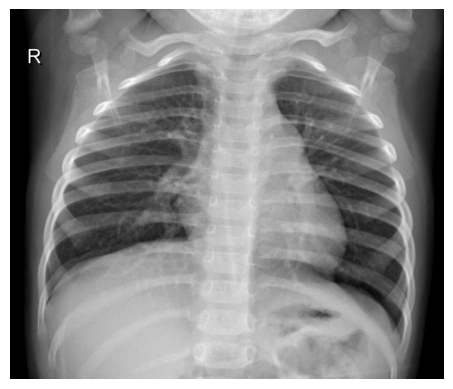

In [9]:
n = random.randint(0, len(train_data)-1)
print(f"{train_data[n]}")
img = cv2.imread(train_data[n])
print(f"Image size => {img.shape}")
plt.imshow(img)
plt.axis('off')

In [10]:
def normalize(img):
    return img/255

train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

# Make Dataset

In [11]:
class Customdataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)

        return img

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)

        if self.transform is not None:
            img = self.transform(PIL.Image.fromarray(img))

        return img, torch.from_numpy(label)

In [12]:
train_dataset = Customdataset(train_data, train_label, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [13]:
f, l = next(iter(train_dataloader))

In [14]:
print(f"Feature shape : {f[0].shape}")

Feature shape : torch.Size([3, 256, 256])


# Define Model

In [15]:
import timm

class Model(nn.Module):
    def __init__(self, classes=2):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)

        return x

In [16]:
model = Model().to(device)

# Define Loss, Optimizer

In [17]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])

# Training

In [18]:
def train_loop(dataloader, model, optimizer, loss_fn, model_save_path):
    model.train()

    size = len(dataloader)
    datasize = len(dataloader.dataset)

    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X,y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 20 == 0:
                print(f"Batch loss : {(loss/size):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [19]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, CFG['model_save_path'])

Start epoch : 1
Batch loss : 0.00852 0/82
Batch loss : 0.00575 20/82
Batch loss : 0.00440 40/82
Batch loss : 0.00398 60/82
Batch loss : 0.00446 80/82
Loss : 0.39297 ACC : 92.12%
End epoch : 1
Epoch time : 2.0 min 36.82230305671692 sec

Start epoch : 2
Batch loss : 0.00413 0/82
Batch loss : 0.00407 20/82
Batch loss : 0.00391 40/82
Batch loss : 0.00401 60/82
Batch loss : 0.00409 80/82
Loss : 0.33601 ACC : 97.74%
End epoch : 2
Epoch time : 2.0 min 2.9036943912506104 sec

Start epoch : 3
Batch loss : 0.00389 0/82
Batch loss : 0.00402 20/82
Batch loss : 0.00397 40/82
Batch loss : 0.00394 60/82
Batch loss : 0.00406 80/82
Loss : 0.33131 ACC : 98.18%
End epoch : 3
Epoch time : 2.0 min 1.03806734085083 sec

Start epoch : 4
Batch loss : 0.00383 0/82
Batch loss : 0.00383 20/82
Batch loss : 0.00401 40/82
Batch loss : 0.00394 60/82
Batch loss : 0.00417 80/82
Loss : 0.32606 ACC : 98.72%
End epoch : 4
Epoch time : 2.0 min 1.4508113861083984 sec

Start epoch : 5
Batch loss : 0.00382 0/82
Batch loss : 

Text(0.5, 1.0, 'Train Loss')

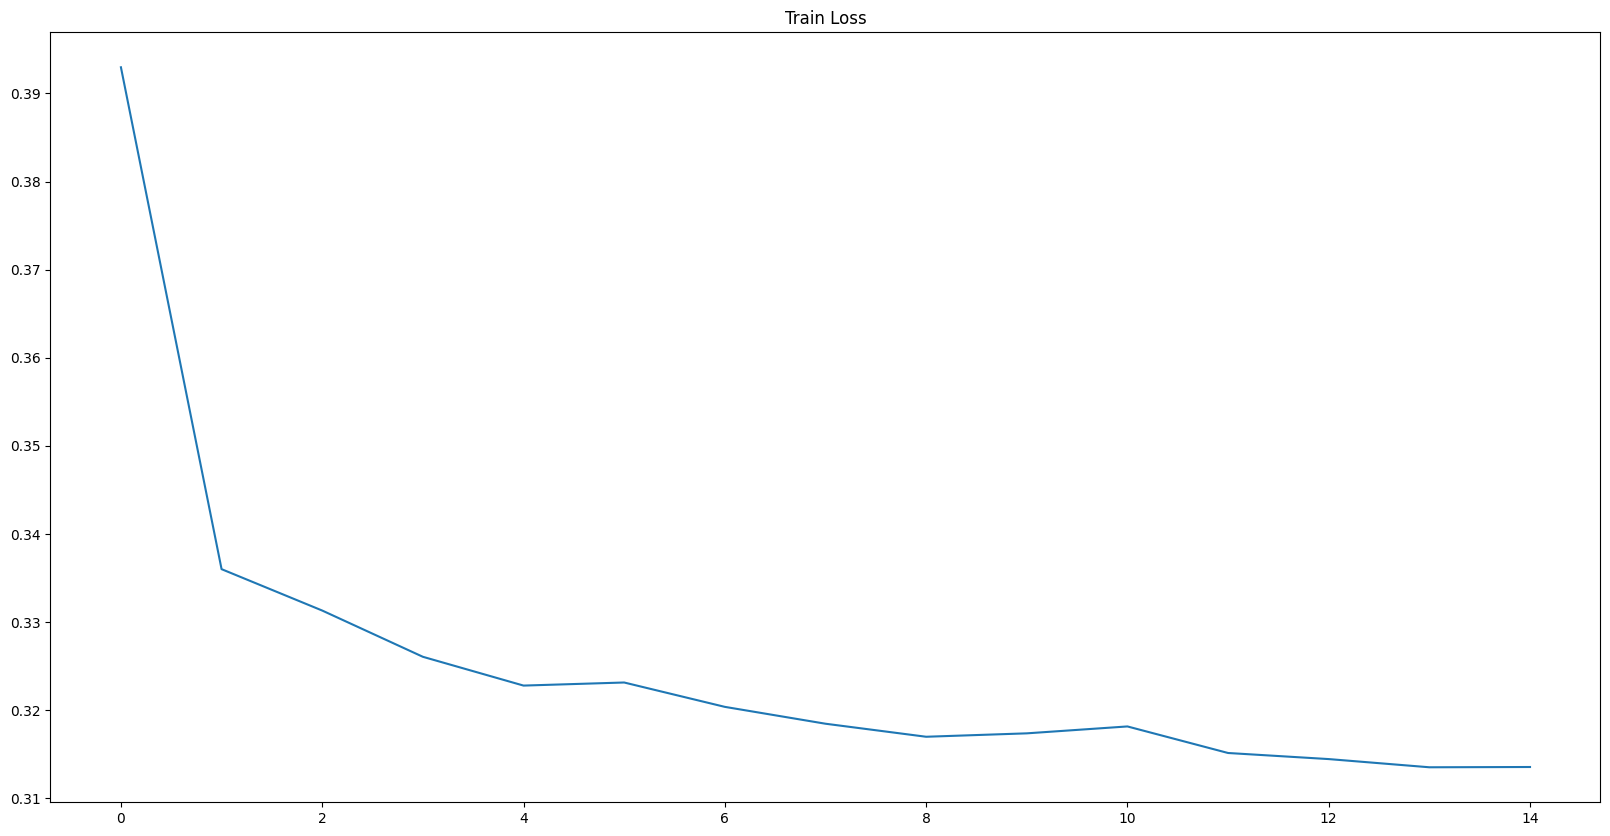

In [20]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist, label='train_loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Acc')

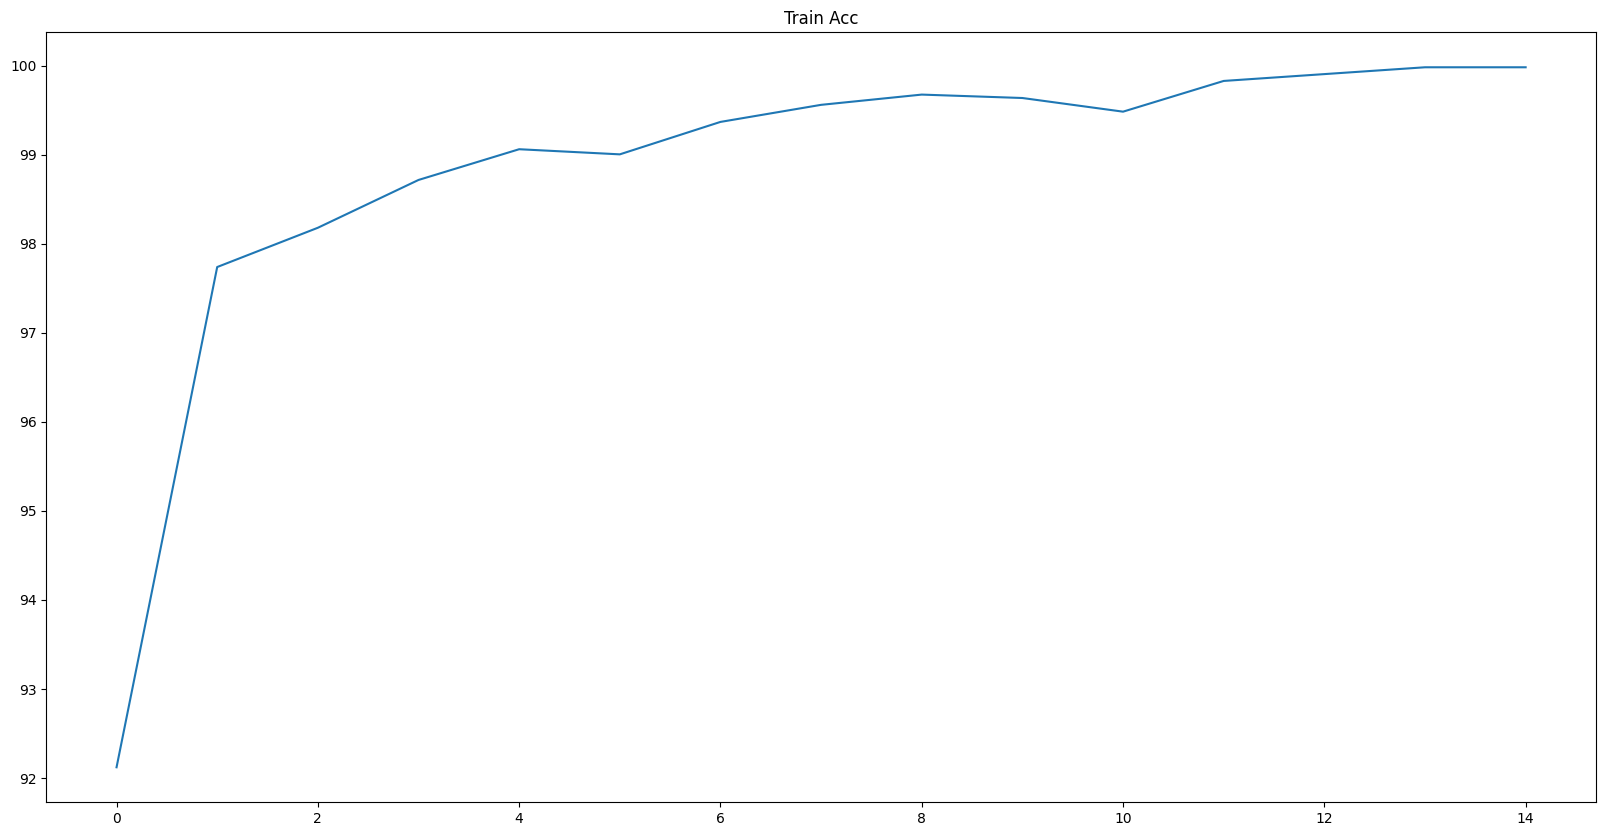

In [21]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist, label='train_acc')
plt.title('Train Acc')

# TEST

In [22]:
test_dataset = Customdataset(test_data, test_label, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [23]:
def test_loop(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred=[]
    target=[]

    for (X,y) in dataloader:
        for t in y:
            target.append(t[1].detach().tolist())

        X = X.to(device).float()
        y = y.to(device).float()

        output = model(X)

        for o in output:
            pred.append(o[1].detach().cpu().tolist())

    return target, pred

In [24]:
target, pred = test_loop(test_dataloader, model, CFG['model_save_path'])

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

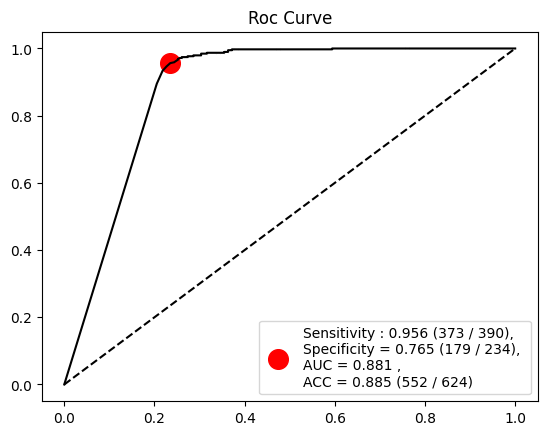

In [27]:
auc = roc_auc_score(target, pred)

fpr, tpr, thresholds = roc_curve(target, pred)
J=tpr-fpr
idx = np.argmax(J)

best_thresh = thresholds[idx]
sens, spec = tpr[idx], 1-fpr[idx]

test_patient = len(test_p)
test_normal_patient = len(test_normal)

acc = (sens*test_patient + spec * test_normal_patient) / (test_patient + test_normal_patient)
auc = roc_auc_score(target, pred)

plt.title("Roc Curve")
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05)
plt.scatter(fpr[idx], tpr[idx], marker='o', s=200, color='r',
            label = 'Sensitivity : %.3f (%d / %d), \nSpecificity = %.3f (%d / %d), \nAUC = %.3f , \nACC = %.3f (%d / %d)' % (sens, (sens*test_patient), test_patient, spec, (spec*test_normal_patient), test_normal_patient, auc, acc, sens*test_patient+spec*test_normal_patient, test_patient+test_normal_patient))
plt.legend()